In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


**Directions For Running Code**

We coded this in Google CoLab and we downloaded the dataset into our google drive at the path 'content/drive/MyDrive/CS4120_Project/poems/'. We reference this path repeatedly in our code in order to pull in the different poems that we use to train our model. In order to run our code succesfully, the dataset must be downloaded and the path has to be changed to point to wherever you save the dataset to. Once you do this the code to import and prep the data should work as intended.

We split the notebook into sections. The first section, Unzipping files, is there so that we could unzip the files in our Google Drive. This code does not need to be run since you will have the data downloaded somewhere else. The next section, Imports, will work as long as you have the proper packages installed. If you do not you will need to install those on your machine. 

The next section is where the datasets get imported. You should be able to run every cell in this section as long as you change the filepaths to point to where you stored the data. Make sure you run every subsection that we split the code into. The next section is where we prepare the data. This section should be able to run from top to bottom no problem.

After this section comes the model training section. First, run the 'helper functions' subsection. This allows you to run any cell in the rest of the section. However, you cannot run every cell. We included five different ways to train models for each of the different datasets we are using. Running just one of these can take hours, and running all of them would cause the runtime to error out. The football/epitaph models are the quickest to run since the datasets are smaller. The positive/negative models take the longest since they are quite large. You will only be able to generate poetry using the models that you run in this section. The best performing models are the LSTM models that run for 100 epochs and 32 batch size, but they take a while. 


The final section is where the poetry is generated. Again in this section you should first run the 'helper functions' subsection. This section then contains a code block that for each model on each dataset that you could have possibly trained. You will only be able to generate poetry using the model that you trained. Navigate through the different subsections to locate the exact model that you trained. Then run that block of code to generate different poems.


When generating poetry, feel free to copy the line of code at the bottom of this explanation and create a new cell. This code will generate a single poem to your specified parameters. Replace 'num_lines' with the number of lines you want the poem to be and 'line_length' with how long you want each line to be. Then replace 'data' in the get_seed() function with the dataset that you are using (ex. ep_data, positive_data, etc.). Replace 'model' with the model that you are using (ex. football_model, negative_model4, etc.). Replace tokenizer with the tokenizer you are using (ex. epitaph_tokenizer, postive_tokenizer, etc.). Replace seq_len with the sequence length that you are using (ex. foot_ep_sequence_length, negative_sequence_length, etc.). Locating all of these different variables will require you to look back at both the model training section and the data prepping section to see what your model is using. You can run this new block of code as much as you want to keep generating new poems. 

make_poem(num_lines, line_length, get_seed(data), model, tokenizer, seq_len)

If you have any questions please reach out to us!

## Unzipping files

In [ ]:
# unzipping files to directory
!unzip -u "/content/drive/MyDrive/CS4120_Project/archive.zip" -d "/content/drive/MyDrive/CS4120_Project/poems"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsReadPoetryUnderstandPoetryPoembyGajananMishra.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsSomeLikePoetryPoembyWislawaSzymborska.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsSpiritOfPoetryThePoembyHenryWadsworthLongfellow.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsTheHallmarkOfPoetryPoembyMichaelShepherd.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsTheNeversOfPoetryPoembyCharlesHarpur.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsThePoetryOfLifePoembyFriedrichSchiller.txt  
  inflating: /content/drive/MyDrive/CS4120_Project/poems/topics/poetry/PoetryPoemsTheProgressOfPoetryPoembyJonathanSwift.txt  
  inflating: /content/drive/MyDrive/CS4120_Pr

## Imports

In [ ]:
# Import statements
import os
import string 
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Getting different datasets

### Helper functions

In [ ]:
# Removes punctuation from a given list of strings
def remove_punc(string_list):

  table = str.maketrans('', '', string.punctuation)
  no_punc = [w.translate(table) for w in string_list]

  return no_punc

In [ ]:
# Takes a directory and outputs the contents of the files as a list
def read_files(directory):

  data = []

  for filename in os.listdir(directory):
    path = directory + "/" + str(filename)
    with open(path) as file:
      lines = file.readlines()
      data.append(lines)

  return data

In [ ]:
# Removes new line (\n) characters from list of strings
def remove_new_line(string_list):
  new_list = []
  for line in string_list:
    new_line = line.replace('\n', '')
    new_list.append(new_line)

  return new_list

In [ ]:
# Flattens the list of lists into one list
def flatten_list(old_list):
  new_list = [item for sublist in old_list for item in sublist]

  return new_list

### Grabbing epitaph data

In [ ]:
# Reading the epitaph files into a list
epitaph_directory = "/content/drive/MyDrive/CS4120_Project/poems/forms/epitaph"
epitaph_data = read_files(epitaph_directory)

In [ ]:
# Flattening list of lists into one list
epitaph_flat = flatten_list(epitaph_data)

# Removing a line that contains names of authors 
epitaph_flat = [x for x in epitaph_flat if 'Jay Thomas Aubin' not in x]

In [ ]:
# Removing the new line characters from the data
ep_data = remove_new_line(epitaph_flat)

In [ ]:
# Removing punctuation
ep_data = remove_punc(ep_data)

In [ ]:
print(len(ep_data))

1681


### Grabbing football topic data

In [ ]:
# Reading the football files into a list

football_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/football"
football_data = read_files(football_directory)

In [ ]:
# Flattening list of lists into one list
football_flat = flatten_list(football_data)

# Removing lines that contain things other than poetry 
football_flat = [x for x in football_flat if 'haiku haiku' not in x and
                 '(c)' not in x and 'আ' not in x and '_____________' not in x and
                 'Sonnets |' not in x and '17.06.2014' not in x and 
                 'Photographers, Cinematography' not in x and 'Copyright 2005' not in x and 
                 'Tom Zart' not in x and 'http:' not in x and '601 Poems' not in x and 
                 '2/2/08' not in x and '(June 7' not in x and 'য়া' not in x]

# Deleting chunk of lines in another language
del football_flat[889:906]

In [ ]:
# Removing new line characters
foot_data = remove_new_line(football_flat)

In [ ]:
# Removing punctuation
foot_data = remove_punc(foot_data)

In [ ]:
print(len(foot_data))

2252


### Combining epitaph and football data

In [ ]:
# Combining the football and epitaph data into one list
foot_ep_data = foot_data + ep_data 

In [ ]:
print(len(foot_ep_data))

3933


### Making large dataset of positive topics

In [ ]:
# Reading the beautiful files into a list

beautiful_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/beautiful"
beautiful_data = read_files(beautiful_directory)

In [ ]:
# Flattening beautiful data
beautiful_flat = flatten_list(beautiful_data)

In [ ]:
# Reading the childhood files into a list

childhood_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/childhood"
childhood_data = read_files(childhood_directory)

In [ ]:
# Flattening childhood data
childhood_flat = flatten_list(childhood_data)

In [ ]:
# Reading the laughter files into a list

laughter_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/laughter"
laughter_data = read_files(laughter_directory)

In [ ]:
# Flattening laughter data
laughter_flat = flatten_list(laughter_data)

In [ ]:
# Reading the happy files into a list

happy_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/happy"
happy_data = read_files(happy_directory)

In [ ]:
# Flattening happy data
happy_flat = flatten_list(happy_data)

In [ ]:
# Reading the happiness files into a list

happiness_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/happiness"
happiness_data = read_files(happiness_directory)

In [ ]:
# Flattening happiness data
happiness_flat = flatten_list(happiness_data)

In [ ]:
# Reading the joy files into a list

joy_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/joy"
joy_data = read_files(joy_directory)

In [ ]:
# Flattening joy data
joy_flat = flatten_list(joy_data)

In [ ]:
# Reading the love files into a list

love_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/love"
love_data = read_files(love_directory)

In [ ]:
# Flattening love data
love_flat = flatten_list(love_data)

In [ ]:
# Combining all the data into one positive dataset
positive_flat = love_flat + joy_flat + happiness_flat + happy_flat + laughter_flat + childhood_flat + beautiful_flat

In [ ]:
# Removing new line characters
positive_data = remove_new_line(positive_flat)

In [ ]:
# Removing punctuation
positive_data = remove_punc(positive_data)

In [ ]:
# Removing lines that just repeat the topic over and over
positive_data = [x for x in positive_data if 'love love love love love' not in x and
                 'happy happy happy happy happy' not in x and 
                 'happiness happiness happiness happiness' not in x and
                 ' beautiful beautiful beautiful beautiful' not in x and
                 'joy joy joy joy joy' not in x and 
                 'laughter laughter laughter laughter' not in x and 
                 'childhood childhood childhood' not in x]

In [ ]:
print(len(positive_data))

18447


### Making large dataset of negative topics

In [ ]:
# Reading the lonely files into a list

lonely_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/lonely"
lonely_data = read_files(lonely_directory)

In [ ]:
# Flattening the lonely data
lonely_flat = flatten_list(lonely_data)

In [ ]:
# Reading the anger files into a list

anger_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/anger"
anger_data = read_files(anger_directory)

In [ ]:
# Flattening the anger data
anger_flat = flatten_list(anger_data)

In [ ]:
# Reading the despair filesinto a list

despair_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/despair"
despair_data = read_files(despair_directory)

In [ ]:
# Flattening the despair data
despair_flat = flatten_list(despair_data)

In [ ]:
# Reading the dark files into a list

dark_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/dark"
dark_data = read_files(dark_directory)

In [ ]:
# Flattening the dark data
dark_flat = flatten_list(dark_data)

In [ ]:
# Reading the depression files into a list

depression_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/depression"
depression_data = read_files(depression_directory)

In [ ]:
# Flattening the depression data
depression_flat = flatten_list(depression_data)

In [ ]:
# Reading the death files into a list

death_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/death"
death_data = read_files(death_directory)

In [ ]:
# Flattening the death data
death_flat = flatten_list(death_data)

In [ ]:
# Reading the fear files into a list

fear_directory = "/content/drive/MyDrive/CS4120_Project/poems/topics/fear"
fear_data = read_files(fear_directory)

In [ ]:
# Flattening the fear data
fear_flat = flatten_list(fear_data)

In [ ]:
# Combining all the data into one negative dataset
negative_flat = lonely_flat + anger_flat + despair_flat + dark_flat + depression_flat + death_flat + fear_flat

In [ ]:
# Removing new line characters
negative_data = remove_new_line(negative_flat)

In [ ]:
# Removing punctuation
negative_data = remove_punc(negative_data)

In [ ]:
# Removing lines that just repeat the topic over and over
negative_data = [x for x in negative_data if 'fear fear fear fear fear' not in x and
                 'anger anger anger anger anger' not in x and 
                 'death death death death' not in x and
                 'depression depression depression depression' not in x and
                 'despair despair despair despair despair' not in x and 
                 'dark dark dark dark' not in x and 
                 'lonely lonely lonely' not in x]

In [ ]:
print(len(negative_data))

15864


## Preparing data

### Helper functions

In [ ]:
# Converts lines of strings into encoded token sequences
def token_sequence(string_list):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(string_list)
  sequence_tokens = tokenizer.texts_to_sequences(string_list)

  return sequence_tokens, tokenizer

In [ ]:
# Gets the vocabulary size from a given tokenizer
def get_vocab_size(tokenizer):

  return len(tokenizer.word_index) + 1

In [ ]:
# Pads variable length sentences so that they are all the same length
def pad_lines(sequence_list):

  # this creates a list sequences looking one word ahead iteratively for each sentence
  sequences = []
  for s in sequence_list:
    if len(s) > 1:
      for i in range(2, len(s)):
        sequences.append(s[:i])
  
  # this pads the sequences to all be the same length 
  padded_sequences = pad_sequences(sequences, maxlen=15, padding='pre')

  return padded_sequences

In [ ]:
# Obtains the X and y from the padded sequences
def get_X_y(sequence_list, vocab_size):
  X = sequence_list[:, :-1]
  y = sequence_list[:, -1]

  # converting to categorical so model can predict probabilities
  y = to_categorical(y, num_classes=vocab_size)

  return X, y

In [ ]:
# Gets the sequence length for a given X
def sequence_length(X):

  return X.shape[1]

In [ ]:
# Pulls all the necessary metrics from the data
def prep_data(data):
  # Gets sequence tokens and the tokenizer for the data
  sequence_tokens, tokenizer = token_sequence(data)
  # Gets vocab size for the data
  vocab_size = get_vocab_size(tokenizer)
  # Gets padded sequences for the data
  padded = pad_lines(sequence_tokens)
  # Gets X and y for the data
  X, y = get_X_y(padded, vocab_size)
  # Gets the sequence length for the data
  seq_len = sequence_length(X)

  return sequence_tokens, tokenizer, vocab_size, padded, X, y, seq_len

### Prepping epitaph data

In [ ]:
# Assigning needed variables from epitaph data
(epitaph_sequence_tokens, epitaph_tokenizer,
 epitaph_vocab_size, epitaph_padded_sequences,
 epitaph_X, epitaph_y, epitaph_sequence_length) = prep_data(ep_data)

In [ ]:
print('Epitaph vocabulary Size: {}'.format(epitaph_vocab_size))

Epitaph vocabulary Size: 3317


### Prepping football data

In [ ]:
# Assigning needed variables from football data
(football_sequence_tokens, football_tokenizer,
 football_vocab_size, football_padded_sequences,
 football_X, football_y, football_sequence_length) = prep_data(foot_data)

In [ ]:
print('Football vocabulary size: {}'.format(football_vocab_size))

Football vocabulary size: 3570


### Prepping football/epitaph combination data

In [ ]:
# Assigning needed variables from football/epitaph combination data
(foot_ep_sequence_tokens, foot_ep_tokenizer,
 foot_ep_vocab_size, foot_ep_padded_sequences,
 foot_ep_X, foot_ep_y, foot_ep_sequence_length) = prep_data(foot_ep_data)

In [ ]:
print('Football/Epitaph vocabulary size: {}'.format(foot_ep_vocab_size))

Football/Epitaph vocabulary size: 5847


### Prepping positive data

In [ ]:
# Assigning needed variables from positive data
(positive_sequence_tokens, positive_tokenizer,
 positive_vocab_size, positive_padded_sequences,
 positive_X, positive_y, positive_sequence_length) = prep_data(positive_data)

In [ ]:
print('Positive vocabulary size: {}'.format(positive_vocab_size))

Positive vocabulary size: 12914


### Prepping negative data

In [ ]:
# Assigning needed variables from negative data
(negative_sequence_tokens, negative_tokenizer,
 negative_vocab_size, negative_padded_sequences,
 negative_X, negative_y, negative_sequence_length) = prep_data(negative_data)

In [ ]:
print('Negative vocabulary size: {}'.format(negative_vocab_size))

Negative vocabulary size: 11549


## Model training

### Helper functions

In [ ]:
# Gets an untrained LSTM model
def get_LSTM_model(vocab_size, sequence_len, optimizer='adam'):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=sequence_len))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
# Gets an untrained Simple RNN model
def get_RNN_model(vocab_size, sequence_len, optimizer='adam'):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=sequence_len))
  model.add(SimpleRNN(100, return_sequences=True))
  model.add(SimpleRNN(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
# Gets an untrained GRU model
def get_GRU_model(vocab_size, sequence_len, optimizer='adam'):
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=sequence_len))
  model.add(GRU(100, return_sequences=True))
  model.add(GRU(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
# Trains the model on the given data
def train_model(model, X, y, batch_size, epochs):
  mod_history = model.fit(X, y, batch_size=batch_size, epochs=epochs)

  return mod_history

In [ ]:
# Plots the given metric for the given model history
def plot_model_history(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel('Epcohs')
  plt.ylabel(metric)
  plt.legend([metric])
  plt.show()

### Training different models

#### Training football models

In [ ]:
# Training an LSTM model on the footabll data for 100 epochs
football_model = get_LSTM_model(football_vocab_size, football_sequence_length)
football_history = train_model(football_model, football_X, football_y, 32, 100)

Epoch 1/100
361/361 [==============================] - 17s 38ms/step - loss: 6.8587 - accuracy: 0.0636
Epoch 2/100
361/361 [==============================] - 14s 37ms/step - loss: 6.3868 - accuracy: 0.0689
Epoch 3/100
361/361 [==============================] - 13s 37ms/step - loss: 6.3080 - accuracy: 0.0689
Epoch 4/100
361/361 [==============================] - 13s 37ms/step - loss: 6.1853 - accuracy: 0.0689
Epoch 5/100
361/361 [==============================] - 12s 34ms/step - loss: 6.0623 - accuracy: 0.0698
Epoch 6/100
361/361 [==============================] - 14s 38ms/step - loss: 5.8849 - accuracy: 0.0760
Epoch 7/100
361/361 [==============================] - 14s 39ms/step - loss: 5.7175 - accuracy: 0.0801
Epoch 8/100
361/361 [==============================] - 13s 37ms/step - loss: 5.5652 - accuracy: 0.0827
Epoch 9/100
361/361 [==============================] - 14s 39ms/step - loss: 5.4190 - accuracy: 0.0862
Epoch 10/100
361/361 [==============================] - 13s 36ms/step - l

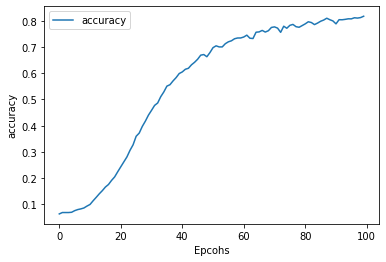

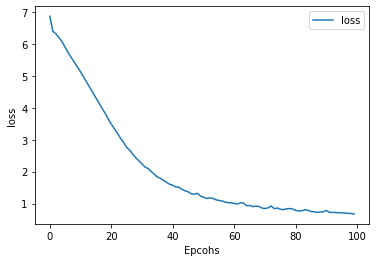

In [ ]:
plot_model_history(football_history, 'accuracy')
plot_model_history(football_history, 'loss')

In [ ]:
# Training an LSTM model on the footabll data for 20 epochs
football_model2 = get_LSTM_model(football_vocab_size, football_sequence_length)
football_history2 = train_model(football_model2, football_X, football_y, 32, 20)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
plot_model_history(football_history2, 'accuracy')
plot_model_history(football_history2, 'loss')

In [ ]:
# Training an LSTM model on the footabll data for 100 epochs and a higher batch size
football_model3 = get_LSTM_model(football_vocab_size, football_sequence_length)
football_history3 = train_model(football_model3, football_X, football_y, 100, 100)

In [ ]:
plot_model_history(football_history3, 'accuracy')
plot_model_history(football_history3, 'loss')

In [ ]:
# Training a SimpleRNN on the football data for 100 epochs
football_model4 = get_RNN_model(football_vocab_size, football_sequence_length)
football_history4 = train_model(football_model4, football_X, football_y, 32, 100)

Epoch 1/100
361/361 [==============================] - 10s 21ms/step - loss: 6.7865 - accuracy: 0.0668
Epoch 2/100
361/361 [==============================] - 8s 23ms/step - loss: 6.2203 - accuracy: 0.0689
Epoch 3/100
361/361 [==============================] - 8s 23ms/step - loss: 5.9486 - accuracy: 0.0782
Epoch 4/100
361/361 [==============================] - 8s 22ms/step - loss: 5.6640 - accuracy: 0.0878
Epoch 5/100
361/361 [==============================] - 8s 23ms/step - loss: 5.3831 - accuracy: 0.0997
Epoch 6/100
361/361 [==============================] - 8s 22ms/step - loss: 5.1064 - accuracy: 0.1168
Epoch 7/100
361/361 [==============================] - 8s 22ms/step - loss: 4.8490 - accuracy: 0.1333
Epoch 8/100
361/361 [==============================] - 8s 23ms/step - loss: 4.5918 - accuracy: 0.1522
Epoch 9/100
361/361 [==============================] - 9s 24ms/step - loss: 4.3364 - accuracy: 0.1712
Epoch 10/100
361/361 [==============================] - 9s 24ms/step - loss: 4.08

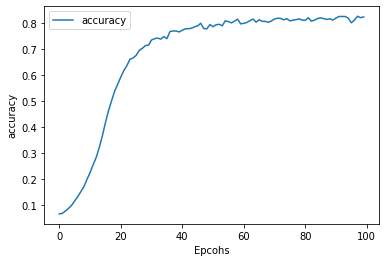

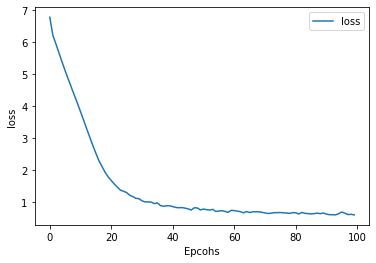

In [ ]:
plot_model_history(football_history4, 'accuracy')
plot_model_history(football_history4, 'loss')

In [ ]:
# Training a GRU on the football data for 100 epochs
football_model5 = get_GRU_model(football_vocab_size, football_sequence_length)
football_history5 = train_model(football_model5, football_X, football_y, 32, 20)

In [ ]:
plot_model_history(football_history5, 'accuracy')
plot_model_history(football_history5, 'loss')

#### Training epitaph models

In [ ]:
# Training an LSTM model on the epitaph data for 100 epochs
epitaph_model = get_LSTM_model(epitaph_vocab_size, epitaph_sequence_length)
epitaph_history = train_model(epitaph_model, epitaph_X, epitaph_y, 32, 100)

Epoch 1/100
254/254 [==============================] - 48s 40ms/step - loss: 7.0755 - accuracy: 0.0430
Epoch 2/100
254/254 [==============================] - 10s 41ms/step - loss: 6.4823 - accuracy: 0.0447
Epoch 3/100
254/254 [==============================] - 10s 39ms/step - loss: 6.3409 - accuracy: 0.0467
Epoch 4/100
254/254 [==============================] - 10s 39ms/step - loss: 6.2039 - accuracy: 0.0486
Epoch 5/100
254/254 [==============================] - 11s 41ms/step - loss: 6.0820 - accuracy: 0.0546
Epoch 6/100
254/254 [==============================] - 10s 39ms/step - loss: 6.0024 - accuracy: 0.0577
Epoch 7/100
254/254 [==============================] - 10s 39ms/step - loss: 5.9304 - accuracy: 0.0583
Epoch 8/100
254/254 [==============================] - 11s 42ms/step - loss: 5.8511 - accuracy: 0.0596
Epoch 9/100
254/254 [==============================] - 11s 45ms/step - loss: 5.7630 - accuracy: 0.0628
Epoch 10/100
254/254 [==============================] - 11s 44ms/step - l

In [ ]:
plot_model_history(epitaph_history, 'accuracy')
plot_model_history(epitaph_history, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 20 epochs
epitaph_model2 = get_LSTM_model(epitaph_vocab_size, epitaph_sequence_length)
epitaph_history2 = train_model(epitaph_model2, epitaph_X, epitaph_y, 32, 20)

In [ ]:
plot_model_history(epitaph_history2, 'accuracy')
plot_model_history(epitaph_history2, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 100 epochs and a higher batch size
epitaph_model3 = get_LSTM_model(epitaph_vocab_size, epitaph_sequence_length)
epitaph_history3 = train_model(epitaph_model3, epitaph_X, epitaph_y, 100, 100)

In [ ]:
plot_model_history(epitaph_history3, 'accuracy')
plot_model_history(epitaph_history3, 'loss')

In [ ]:
# Training a SimpleRNN model on the epitaph data for 100 epochs 
epitaph_model4 = get_RNN_model(epitaph_vocab_size, epitaph_sequence_length)
epitaph_history4 = train_model(epitaph_model4, epitaph_X, epitaph_y, 32, 100)

In [ ]:
plot_model_history(epitaph_history4, 'accuracy')
plot_model_history(epitaph_history4, 'loss')

In [ ]:
# Training a GRU model on the epitaph data for 100 epochs 
epitaph_model5 = get_GRU_model(epitaph_vocab_size, epitaph_sequence_length)
epitaph_history5 = train_model(epitaph_model5, epitaph_X, epitaph_y, 32, 100)

In [ ]:
plot_model_history(epitaph_history5, 'accuracy')
plot_model_history(epitaph_history5, 'loss')

#### Training football/epitaph combination models

In [ ]:
# Training an LSTM on the football/epitaph combination data for 100 epochs
foot_ep_model = get_LSTM_model(foot_ep_vocab_size, foot_ep_sequence_length)
foot_ep_history = train_model(foot_ep_model, foot_ep_X, foot_ep_y, 32, 100)

Epoch 1/100
614/614 [==============================] - 29s 40ms/step - loss: 7.0227 - accuracy: 0.0581
Epoch 2/100
614/614 [==============================] - 25s 40ms/step - loss: 6.5655 - accuracy: 0.0595
Epoch 3/100
614/614 [==============================] - 25s 40ms/step - loss: 6.3846 - accuracy: 0.0620
Epoch 4/100
614/614 [==============================] - 25s 41ms/step - loss: 6.2593 - accuracy: 0.0712
Epoch 5/100
614/614 [==============================] - 25s 40ms/step - loss: 6.1671 - accuracy: 0.0733
Epoch 6/100
614/614 [==============================] - 25s 41ms/step - loss: 6.0855 - accuracy: 0.0750
Epoch 7/100
614/614 [==============================] - 25s 41ms/step - loss: 6.0008 - accuracy: 0.0777
Epoch 8/100
614/614 [==============================] - 25s 40ms/step - loss: 5.8955 - accuracy: 0.0806
Epoch 9/100
614/614 [==============================] - 25s 41ms/step - loss: 5.7830 - accuracy: 0.0857
Epoch 10/100
614/614 [==============================] - 29s 47ms/step - l

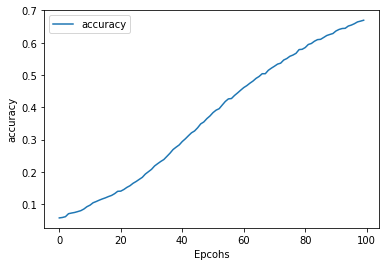

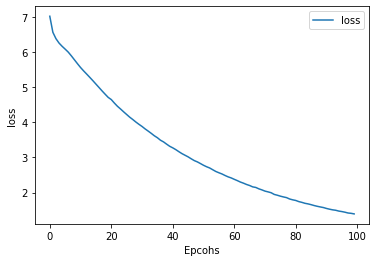

In [ ]:
plot_model_history(foot_ep_history, 'accuracy')
plot_model_history(foot_ep_history, 'loss')

In [ ]:
# Training an LSTM on the football/epitaph combination data for 20 epochs
foot_ep_model2 = get_LSTM_model(foot_ep_vocab_size, foot_ep_sequence_length)
foot_ep_history2 = train_model(foot_ep_model2, foot_ep_X, foot_ep_y, 32, 20)

Epoch 1/20
614/614 [==============================] - 28s 40ms/step - loss: 7.0363 - accuracy: 0.0590
Epoch 2/20
614/614 [==============================] - 24s 40ms/step - loss: 6.5795 - accuracy: 0.0595
Epoch 3/20
614/614 [==============================] - 26s 43ms/step - loss: 6.4084 - accuracy: 0.0617
Epoch 4/20
614/614 [==============================] - 25s 40ms/step - loss: 6.2771 - accuracy: 0.0699
Epoch 5/20
614/614 [==============================] - 24s 40ms/step - loss: 6.1747 - accuracy: 0.0731
Epoch 6/20
614/614 [==============================] - 25s 40ms/step - loss: 6.0705 - accuracy: 0.0747
Epoch 7/20
614/614 [==============================] - 25s 40ms/step - loss: 5.9725 - accuracy: 0.0782
Epoch 8/20
614/614 [==============================] - 25s 40ms/step - loss: 5.8584 - accuracy: 0.0816
Epoch 9/20
614/614 [==============================] - 32s 52ms/step - loss: 5.7477 - accuracy: 0.0873
Epoch 10/20
614/614 [==============================] - 30s 49ms/step - loss: 5.646

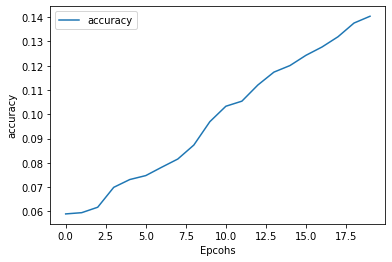

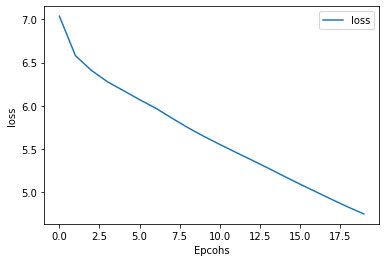

In [ ]:
plot_model_history(foot_ep_history2, 'accuracy')
plot_model_history(foot_ep_history2, 'loss')

In [ ]:
# Training an LSTM on the football/epitaph combination data for 100 epochs and a higher batch size
foot_ep_model3 = get_LSTM_model(foot_ep_vocab_size, foot_ep_sequence_length)
foot_ep_history3 = train_model(foot_ep_model3, foot_ep_X, foot_ep_y, 100, 100)

Epoch 1/100
197/197 [==============================] - 19s 80ms/step - loss: 7.1839 - accuracy: 0.0583
Epoch 2/100
197/197 [==============================] - 16s 80ms/step - loss: 6.6514 - accuracy: 0.0595
Epoch 3/100
197/197 [==============================] - 16s 82ms/step - loss: 6.5305 - accuracy: 0.0595
Epoch 4/100
197/197 [==============================] - 16s 80ms/step - loss: 6.3971 - accuracy: 0.0613
Epoch 5/100
197/197 [==============================] - 16s 80ms/step - loss: 6.2831 - accuracy: 0.0692
Epoch 6/100
197/197 [==============================] - 16s 81ms/step - loss: 6.1981 - accuracy: 0.0715
Epoch 7/100
197/197 [==============================] - 16s 81ms/step - loss: 6.1122 - accuracy: 0.0735
Epoch 8/100
197/197 [==============================] - 16s 81ms/step - loss: 6.0296 - accuracy: 0.0766
Epoch 9/100
197/197 [==============================] - 16s 81ms/step - loss: 5.9549 - accuracy: 0.0775
Epoch 10/100
197/197 [==============================] - 16s 82ms/step - l

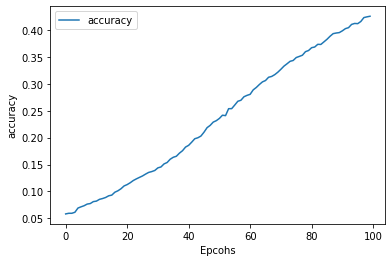

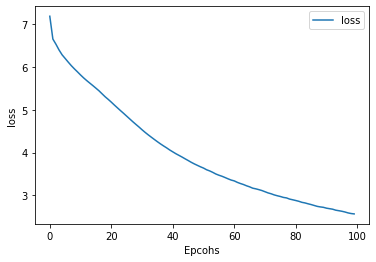

In [ ]:
plot_model_history(foot_ep_history3, 'accuracy')
plot_model_history(foot_ep_history3, 'loss')

In [ ]:
# Training a SimpleRNN on the football/epitaph combination data for 100 epochs
foot_ep_model4 = get_RNN_model(foot_ep_vocab_size, foot_ep_sequence_length)
foot_ep_history4 = train_model(foot_ep_model4, foot_ep_X, foot_ep_y, 32, 100)

Epoch 1/100
614/614 [==============================] - 16s 24ms/step - loss: 7.0103 - accuracy: 0.0567
Epoch 2/100
614/614 [==============================] - 14s 24ms/step - loss: 6.5933 - accuracy: 0.0606
Epoch 3/100
614/614 [==============================] - 14s 23ms/step - loss: 6.3534 - accuracy: 0.0701
Epoch 4/100
614/614 [==============================] - 15s 24ms/step - loss: 6.1507 - accuracy: 0.0723
Epoch 5/100
614/614 [==============================] - 15s 24ms/step - loss: 5.9889 - accuracy: 0.0770
Epoch 6/100
614/614 [==============================] - 14s 24ms/step - loss: 5.8483 - accuracy: 0.0828
Epoch 7/100
614/614 [==============================] - 15s 24ms/step - loss: 5.6946 - accuracy: 0.0935
Epoch 8/100
614/614 [==============================] - 15s 24ms/step - loss: 5.5405 - accuracy: 0.1046
Epoch 9/100
614/614 [==============================] - 14s 23ms/step - loss: 5.3905 - accuracy: 0.1182
Epoch 10/100
614/614 [==============================] - 15s 24ms/step - l

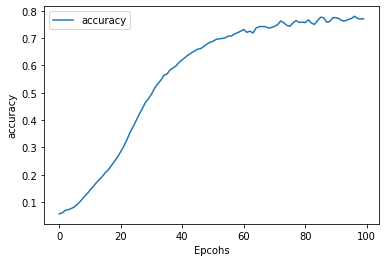

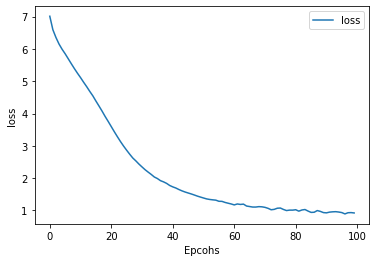

In [ ]:
plot_model_history(foot_ep_history4, 'accuracy')
plot_model_history(foot_ep_history4, 'loss')

In [ ]:
# Training a GRU on the football/epitaph combination data for 100 epochs
foot_ep_model5 = get_GRU_model(foot_ep_vocab_size, foot_ep_sequence_length)
foot_ep_history5 = train_model(foot_ep_model5, foot_ep_X, foot_ep_y, 32, 100)

Epoch 1/100
614/614 [==============================] - 26s 36ms/step - loss: 7.1552 - accuracy: 0.0574
Epoch 2/100
614/614 [==============================] - 22s 36ms/step - loss: 6.7309 - accuracy: 0.0595
Epoch 3/100
614/614 [==============================] - 22s 36ms/step - loss: 6.6924 - accuracy: 0.0595
Epoch 4/100
614/614 [==============================] - 22s 36ms/step - loss: 6.6804 - accuracy: 0.0595
Epoch 5/100
614/614 [==============================] - 23s 37ms/step - loss: 6.6036 - accuracy: 0.0595
Epoch 6/100
614/614 [==============================] - 22s 36ms/step - loss: 6.4633 - accuracy: 0.0634
Epoch 7/100
614/614 [==============================] - 22s 36ms/step - loss: 6.2706 - accuracy: 0.0724
Epoch 8/100
614/614 [==============================] - 22s 36ms/step - loss: 6.0445 - accuracy: 0.0822
Epoch 9/100
614/614 [==============================] - 22s 36ms/step - loss: 5.8343 - accuracy: 0.0966
Epoch 10/100
614/614 [==============================] - 22s 36ms/step - l

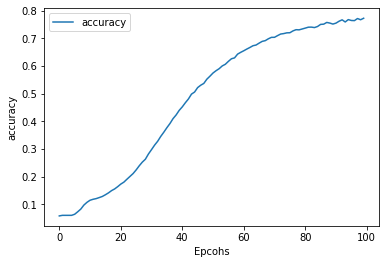

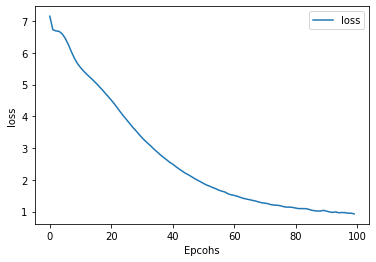

In [ ]:
plot_model_history(foot_ep_history5, 'accuracy')
plot_model_history(foot_ep_history5, 'loss')

#### Training postive models

In [ ]:
# Training an LSTM model on the positive data for 100 epochs
positive_model = get_LSTM_model(positive_vocab_size, positive_sequence_length)
positive_history = train_model(positive_model, positive_X, positive_y, 32, 100)

Epoch 1/100
2443/2443 [==============================] - 134s 54ms/step - loss: 6.7841 - accuracy: 0.0602
Epoch 2/100
2443/2443 [==============================] - 129s 53ms/step - loss: 6.3520 - accuracy: 0.0815
Epoch 3/100
2443/2443 [==============================] - 130s 53ms/step - loss: 6.0480 - accuracy: 0.1018
Epoch 4/100
2443/2443 [==============================] - 130s 53ms/step - loss: 5.8386 - accuracy: 0.1164
Epoch 5/100
2443/2443 [==============================] - 131s 54ms/step - loss: 5.6677 - accuracy: 0.1242
Epoch 6/100
2443/2443 [==============================] - 131s 53ms/step - loss: 5.5125 - accuracy: 0.1310
Epoch 7/100
2443/2443 [==============================] - 130s 53ms/step - loss: 5.3830 - accuracy: 0.1361
Epoch 8/100
2443/2443 [==============================] - 131s 54ms/step - loss: 5.2595 - accuracy: 0.1394
Epoch 9/100
2443/2443 [==============================] - 131s 54ms/step - loss: 5.1453 - accuracy: 0.1451
Epoch 10/100
2443/2443 [======================

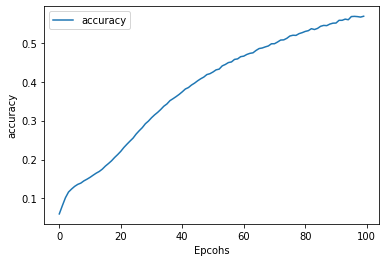

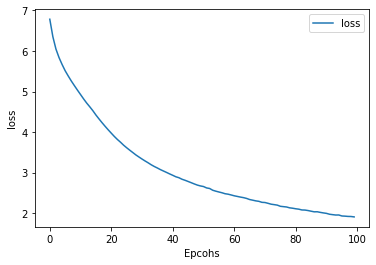

In [ ]:
plot_model_history(positive_history, 'accuracy')
plot_model_history(positive_history, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 20 epochs
positive_model2 = get_LSTM_model(positive_vocab_size, positive_sequence_length)
positive_history2 = train_model(positive_model2, positive_X, positive_y, 32, 20)

In [ ]:
plot_model_history(positive_history2, 'accuracy')
plot_model_history(positive_history2, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 100 epochs and a higher batch size
positive_model3 = get_LSTM_model(positive_vocab_size, positive_sequence_length)
positive_history3 = train_model(positive_model3, positive_X, positive_y, 100, 100)

In [ ]:
plot_model_history(positive_history3, 'accuracy')
plot_model_history(positive_history3, 'loss')

In [ ]:
# Training a SimpleRNN model on the epitaph data for 100 epochs 
positive_model4 = get_RNN_model(positive_vocab_size, positive_sequence_length)
positive_history4 = train_model(positive_model4, positive_X, positive_y, 32, 100)

Epoch 1/100
2443/2443 [==============================] - 91s 37ms/step - loss: 6.7708 - accuracy: 0.0659
Epoch 2/100
2443/2443 [==============================] - 90s 37ms/step - loss: 6.3749 - accuracy: 0.0797
Epoch 3/100
2443/2443 [==============================] - 89s 36ms/step - loss: 6.1621 - accuracy: 0.0872
Epoch 4/100
2443/2443 [==============================] - 89s 36ms/step - loss: 5.9827 - accuracy: 0.0999
Epoch 5/100
2443/2443 [==============================] - 89s 36ms/step - loss: 5.8373 - accuracy: 0.1111
Epoch 6/100
2443/2443 [==============================] - 88s 36ms/step - loss: 5.7148 - accuracy: 0.1187
Epoch 7/100
2443/2443 [==============================] - 88s 36ms/step - loss: 5.6134 - accuracy: 0.1242
Epoch 8/100
2443/2443 [==============================] - 88s 36ms/step - loss: 5.5285 - accuracy: 0.1288
Epoch 9/100
2443/2443 [==============================] - 89s 36ms/step - loss: 5.4506 - accuracy: 0.1337
Epoch 10/100
2443/2443 [==============================]

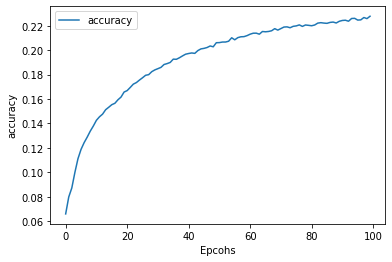

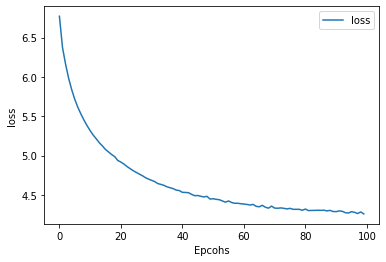

In [ ]:
plot_model_history(positive_history4, 'accuracy')
plot_model_history(positive_history4, 'loss')

In [ ]:
# Training a GRU model on the epitaph data for 100 epochs 
positive_model5 = get_GRU_model(positive_vocab_size, positive_sequence_length)
positive_history5 = train_model(positive_model5, positive_X, positive_y, 32, 100)

Epoch 1/100
  74/2443 [..............................] - ETA: 2:04 - loss: 7.9441 - accuracy: 0.0507

KeyboardInterrupt: ignored

In [ ]:
plot_model_history(positive_history5, 'accuracy')
plot_model_history(positive_history5, 'loss')

#### Training negative models

In [ ]:
# Training an LSTM model on the negative data for 100 epochs
negative_model = get_LSTM_model(negative_vocab_size, negative_sequence_length)
negative_history = train_model(negative_model, negative_X, negative_y, 32, 100)

Epoch 1/100
2268/2268 [==============================] - 172s 72ms/step - loss: 6.7603 - accuracy: 0.0586
Epoch 2/100
2268/2268 [==============================] - 161s 71ms/step - loss: 6.3199 - accuracy: 0.0758
Epoch 3/100
2268/2268 [==============================] - 153s 68ms/step - loss: 6.0482 - accuracy: 0.0887
Epoch 4/100
2268/2268 [==============================] - 191s 84ms/step - loss: 5.8708 - accuracy: 0.0996
Epoch 5/100
2268/2268 [==============================] - 186s 82ms/step - loss: 5.7185 - accuracy: 0.1082
Epoch 6/100
2268/2268 [==============================] - 163s 72ms/step - loss: 5.5782 - accuracy: 0.1149
Epoch 7/100
2268/2268 [==============================] - 177s 78ms/step - loss: 5.4655 - accuracy: 0.1204
Epoch 8/100
2268/2268 [==============================] - 275s 121ms/step - loss: 5.3439 - accuracy: 0.1254
Epoch 9/100
2268/2268 [==============================] - 228s 101ms/step - loss: 5.2369 - accuracy: 0.1312
Epoch 10/100
2268/2268 [====================

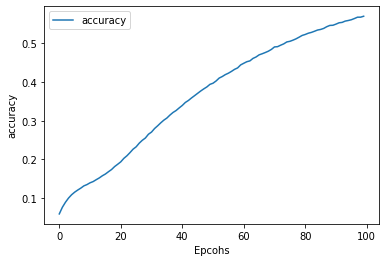

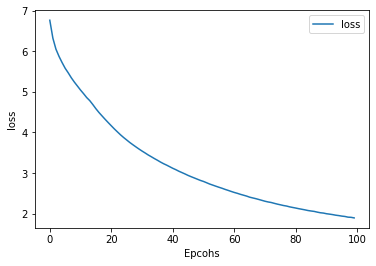

In [ ]:
plot_model_history(negative_history, 'accuracy')
plot_model_history(negative_history, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 20 epochs
negative_model2 = get_LSTM_model(negative_vocab_size, negative_sequence_length)
negative_history2 = train_model(negative_model2, negative_X, negative_y, 32, 20)

In [ ]:
plot_model_history(negative_history2, 'accuracy')
plot_model_history(negative_history2, 'loss')

In [ ]:
# Training an LSTM model on the epitaph data for 100 epochs and a higher batch size
negative_model3 = get_LSTM_model(negative_vocab_size, negative_sequence_length)
negative_history3 = train_model(negative_model3, negative_X, negative_y, 100, 100)

In [ ]:
plot_model_history(negative_history3, 'accuracy')
plot_model_history(negative_history3, 'loss')

In [ ]:
# Training a SimpleRNN model on the epitaph data for 100 epochs 
negative_model4 = get_RNN_model(negative_vocab_size, negative_sequence_length)
negative_history4 = train_model(negative_model4, negative_X, negative_y, 32, 100)

In [ ]:
plot_model_history(negative_history4, 'accuracy')
plot_model_history(negative_history4, 'loss')

In [ ]:
# Training a GRU model on the epitaph data for 100 epochs 
negative_model5 = get_GRU_model(negative_vocab_size, negative_sequence_length)
negative_history5 = train_model(negative_model5, negative_X, negative_y, 32, 100)

In [ ]:
plot_model_history(negative_history5, 'accuracy')
plot_model_history(negative_history5, 'loss')

## Poetry generation

### Helper functions

In [ ]:
# Generates poetry
def make_poem(num_lines, line_length, seed_text, model, tokenizer, seq_len, max_prob=True):

  poem = []
  # iterating through the number of lines
  for i in range(num_lines):
    text = []
    # iterating through the number of words
    for _ in range(line_length):
      # turning the seed text into a sequence that the model can understand
      seq = tokenizer.texts_to_sequences([seed_text])
      seq = pad_sequences(seq, maxlen=seq_len, padding='pre')

      # generating y_pred depending on if we should argmax or sample from model predictions
      if max_prob:
        y_pred = np.argmax(model.predict(seq), axis=1)
      else:
        preds = model.predict(seq).flatten()
        y_pred = np.random.choice(range(len(preds)), p=preds)

      # finding the predicted word in the tokenizers word index
      pred_word = ""
      for w, ind in tokenizer.word_index.items():
        if ind == y_pred:
          pred_word = w
          break

      # updating the seed text with the new word
      seed_text = seed_text + ' ' + pred_word
      # appending new word to the text
      text.append(pred_word)

    # new seed text is last line
    seed_text = text[-1]
    # creating string from list of generated words
    text = ' '.join(text)
    # adding the line to the list of poem lines
    poem.append(text)
    print(text)

  #return poem

In [ ]:
# Function that gets random seed text from list
def get_seed(string_list):

  return random.choice(string_list)

In [ ]:
# Generates poems from the given model and dataset
def generate_poems(model, data, data_name, tokenizer, sequence_len):

  print("Generating a poem from " + data_name + " data of 5 lines and 10 words per line and a fixed seed")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 10, data[5], model, tokenizer, sequence_len)
  print('\n\n')

  print("Generating a poem from " + data_name + " data of 5 lines and 10 words per line and a random seed")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 10, get_seed(data), model, tokenizer, sequence_len)
  print('\n\n')

  print("Generating a poem from " + data_name + " data of 5 lines and 2 words per line")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 2, get_seed(data), model, tokenizer, sequence_len)  
  print('\n\n')

  print("Generating a poem from " + data_name + " data of 5 lines and 10 words per line using probability sampling for predictions and a fixed seed")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 10, data[5], model, tokenizer, sequence_len, max_prob=False)
  print('\n\n')

  print("Generating a poem from " + data_name + " data of 5 lines and 10 words per line using probability sampling for predictions and a random seed")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 10, get_seed(data), model, tokenizer, sequence_len, max_prob=False)
  print('\n\n')

  print("Generating a poem from " + data_name + " data of 5 lines and 10 words per line with a manually entered seed 'to be or not to be'")
  print('---------------------------------------------------------------------\n')
  make_poem(5, 10, 'to be or not to be', model, tokenizer, sequence_len)
  print()

### Generating poems from football data

#### Using LSTM with batch size 32 and 100 epochs

In [ ]:
generate_poems(football_model, foot_data, 'football', football_tokenizer, football_sequence_length)

Generating a poem from football data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

them your maple and licked a wonderful yes of they
do celebrate there in spirits and soothe troubled than t
played it and real seven and is in do do
you go over the sea and the women in the
stands are full of eager with with you men and



Generating a poem from football data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

with with you strive the game for him ebbing but
the ball are gone his way and then us it
is each to their own as the wise one does
logerie the field with the temporary game of the u
get over it in a bat you can biff will



Generating a poem from football data of 5 lines and 2 words per line
---------------------------------------------------------------------

on in
the grand
evangelical mission10th
of hugging
other and



Generating a p

#### Using LSTM with batch size 32 and 20 epochs

In [ ]:
generate_poems(football_model2, foot_data, 'football', football_tokenizer, football_sequence_length)

#### Using LSTM with batch size 100 and 100 epochs

In [ ]:
generate_poems(football_model3, foot_data, 'football', football_tokenizer, football_sequence_length)

#### Using SimpleRNN with batch size 32 and 100 epochs

In [ ]:
generate_poems(football_model4, foot_data, 'football', football_tokenizer, football_sequence_length)

#### Using GRU with batch size 32 and 100 epochs

In [ ]:
generate_poems(football_model5, foot_data, 'football', football_tokenizer, football_sequence_length)

### Generating poems from epitaph data

#### Using LSTM with batch size 32 and 100 epochs

In [ ]:
generate_poems(epitaph_model, ep_data, 'epitaph', epitaph_tokenizer, epitaph_sequence_length)

#### Using LSTM with batch size 32 and 20 epochs

In [ ]:
generate_poems(epitaph_model2, ep_data, 'epitaph', epitaph_tokenizer, epitaph_sequence_length)

#### Using LSTM with batch size 100 and 100 epochs

In [ ]:
generate_poems(epitaph_model3, ep_data, 'epitaph', epitaph_tokenizer, epitaph_sequence_length)

#### Using SimpleRNN model with batch size 32 and 100 epochs

In [ ]:
generate_poems(epitaph_model4, ep_data, 'epitaph', epitaph_tokenizer, epitaph_sequence_length)

#### Using GRU model with batch size 32 and 100 epochs

In [ ]:
generate_poems(epitaph_model5, ep_data, 'epitaph', epitaph_tokenizer, epitaph_sequence_length)

### Generating poems from football/epitaph combination data 

#### Using LSTM with batch size 32 and 100 epochs

In [ ]:
generate_poems(foot_ep_model, foot_ep_data, 'football/epitaph', foot_ep_tokenizer, foot_ep_sequence_length)

Generating a poem from football/epitaph data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

her bower on a mystery a patriots would be saved
the brethrens to protect kids like john weekends parents on
a sunny day he ran that used to see a
football player’s still his every pub on a racing work
is a contact and i can keep us a game



Generating a poem from football/epitaph data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

at my self sing a every to the stones one
name is young getting for with the local and wasting
by named a cipress one beats the bench press which
cloudforms usefully stood to protect forget a program designed to
the dingo club he important can the sell of the



Generating a poem from football/epitaph data of 5 lines and 2 words per line
---------------------------------------------------------------------

gone the
eart

#### Using LSTM with batch size 32 and 20 epochs

In [ ]:
generate_poems(foot_ep_model2, foot_ep_data, 'football/epitaph', foot_ep_tokenizer, foot_ep_sequence_length)

Generating a poem from football/epitaph data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

the game of the game of the game of the
ball of full or be not not not not not
the football of his own shall be not not not
the football of his own shall be not not not
the football of his own shall be not not not



Generating a poem from football/epitaph data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

to be not the game of the game of the
ball of full or be not not not not not
the football of his own shall be not not not
the football of his own shall be not not not
the football of his own shall be not not not



Generating a poem from football/epitaph data of 5 lines and 2 words per line
---------------------------------------------------------------------

is a
athletic the
ball of
the football
is a



Generating a poem from football/epitaph 

#### Using LSTM with batch size 100 and 100 epochs

In [ ]:
generate_poems(foot_ep_model3, foot_ep_data, 'football/epitaph', foot_ep_tokenizer, foot_ep_sequence_length)

Generating a poem from football/epitaph data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

us much of a new brother photograph of the presence
a ballengage in the aeries of the belgium team old
tiney surliest of the stones say is not going to
all a tommy’s be hanmers pretend to fight with a
rounded leather and sword and blazoned and we cant opportunities



Generating a poem from football/epitaph data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

to speak a to all the big game of a
rounded leather and sword and blazoned and we cant opportunities
closely nor fools nor censure the author and reveale the
stands are full of eager through her poem press victories
to the striped shirts whistle his bully vigil much old



Generating a poem from football/epitaph data of 5 lines and 2 words per line
-----------------------------------------------

#### Using SimpleRNN model with batch size 32 and 100 epochs

In [ ]:
generate_poems(foot_ep_model4, foot_ep_data, 'football/epitaph', foot_ep_tokenizer, foot_ep_sequence_length)

Generating a poem from football/epitaph data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

them at their club it was lost their coaching be
the hell is to the pub football stories than watched
jack score and a win to cry the one and
the letters in the words they should be really would
not no give me judge christian played were to yet



Generating a poem from football/epitaph data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

footballsoccer competition yet returns to see he touch find the
earth builds on the visiting team clad in their school
is kaleidoscopic full of chase to their lives to do
not aspire to our banners they are waving with joy
heaven team of play of the billow in this year



Generating a poem from football/epitaph data of 5 lines and 2 words per line
---------------------------------------------------------------------


#### Using GRU model with batch size 32 and 100 epochs

In [ ]:
generate_poems(foot_ep_model5, foot_ep_data, 'football/epitaph', foot_ep_tokenizer, foot_ep_sequence_length)

Generating a poem from football/epitaph data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

football double and four aggressive long as they give my
heart weakens more and greater so all they have him
rather all the hands wrapped in its year in the
stands are full of eager and other marble ye be
it river pond or grave it died against the grand



Generating a poem from football/epitaph data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

is a call too teams by why against they sing
on it poacher tis so calmly that has look up
the worms slip by slip on campus because one given
after yeers of the dingoes and that shines so very
immense wise to have it wont wont be a game



Generating a poem from football/epitaph data of 5 lines and 2 words per line
---------------------------------------------------------------------

from each
morning start

### Generating poems from positive data

#### Using LSTM with batch size 32 and 100 epochs

In [ ]:
generate_poems(positive_model, positive_data, 'positive', positive_tokenizer, positive_sequence_length)

Generating a poem from positive data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

every en flower i’d give me to be instinctive that
only a dedicated to every or i has be almost
then away to utter who hast seen away our little
foreign misses and young ladies gently फूल who plein d’usage
lingering beside very care and the west which is simply



Generating a poem from positive data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

the test of human spirits we are left the hearts
break and make this world in the room and candid
in the green scrubbery all lively and chainmail did we
are here to me head to buy a new artless
in the world precipitates go down the story that nature



Generating a poem from positive data of 5 lines and 2 words per line
---------------------------------------------------------------------

we are
not ignoble
motion

#### Using LSTM with batch size 32 and 20 epochs

In [ ]:
generate_poems(positive_model2, positive_data, 'positive', positive_tokenizer, positive_sequence_length)

#### Using LSTM with batch size 100 and 100 epochs

In [ ]:
generate_poems(positive_model3, positive_data, 'positive', positive_tokenizer, positive_sequence_length)

#### Using SimpleRNN with batch size 32 and 100 epochs

In [ ]:
generate_poems(positive_model4, positive_data, 'positive', positive_tokenizer, positive_sequence_length)

Generating a poem from positive data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

man are a beautiful the beautiful the fait tree i
love you more than the world is a world is
a beautiful sun hills their lives and seen the little
easy were awake into a beautiful the fait tree i
love you more than the world is a world is



Generating a poem from positive data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

morn me shod with the world of the world of
the little beautiful summer near by the world of the
world is a world is a beautiful the fait tree
i love you more than the world is a world
and blue το 15151560 la beautiful de το douceur τα



Generating a poem from positive data of 5 lines and 2 words per line
---------------------------------------------------------------------

as i
love you
are a
little fait
short villas



Generating a p

#### Using GRU with batch size 32 and 100 epochs

In [ ]:
generate_poems(positive_model5, positive_data, 'positive', positive_tokenizer, positive_sequence_length)

### Generating poems from negative data

#### Using LSTM with batch size 32 and 100 epochs

In [ ]:
generate_poems(negative_model, negative_data, 'negative', negative_tokenizer, negative_sequence_length)

Generating a poem from negative data of 5 lines and 10 words per line and a fixed seed
---------------------------------------------------------------------

the flame i can be been away in the dawn
takes deeper through isolation draw birds is no water and
the infinite oblivion shattered you is but all the golden
lads and girls all free with rage and beast upon
the ocean settles dark and her sleep will come his



Generating a poem from negative data of 5 lines and 10 words per line and a random seed
---------------------------------------------------------------------

and therefore oh my strange language friends to all dishonor
and over me deep within my existence for in future
with the blackbirds bolder note a sober as gold are
causing pity to reply about startled and a burning that
i am the small friend of the west pleading in



Generating a poem from negative data of 5 lines and 2 words per line
---------------------------------------------------------------------

enough to
the 

#### Using LSTM with batch size 32 and 20 epochs

In [ ]:
generate_poems(negative_model2, negative_data, 'negative', negative_tokenizer, negative_sequence_length)

#### Using LSTM with batch size 100 and 100 epochs

In [ ]:
generate_poems(negative_model3, negative_data, 'negative', negative_tokenizer, negative_sequence_length)

#### Using SimpleRNN with batch size 32 and 100 epochs

In [ ]:
generate_poems(negative_model4, negative_data, 'negative', negative_tokenizer, negative_sequence_length)

#### Using GRU with batch size 32 and 100 epochs

In [ ]:
generate_poems(negative_model5, negative_data, 'negative', negative_tokenizer, negative_sequence_length)